# Underfitting and Overfitting
Sometimes when adjusting hyperparameters or model structures, we can **get excellent accuracy in training datasets** while we may **get very bad accuracy in testing datasets**. What causing this to happen?

## Training Error and Testing Error
`Training Error` is model error on training datasets, and `Testing Error` is model error on testing datasets. Taking the College Entrance Exam as example, training dataset is like first mock exam and second mock exam and so on, it is just mock exam to test whether you are ready to take the CEE. However, testing dataset is like CEE, where there are questions what you never done but you may slove it with your abilities. It is to test whether the model is good enough to predict each data accurately, which is the abilities of model.  
Blindly reduce training error doesn't mean testing error will descent. What we foucs on first is to reducing testing error in mechine learing models. 

## Model Selection
Above all, we shoule select suitable model before adjusting hyperparameter. Take multilayer perceptron as example, the nubmber of hidden layer ,the number of unit in each hidden layer and activation function all paly a important role.  
We may take lots of effort to select a suitable model, and here is some producures. 

### Validate Datasets
Resever some data outside training and test dataset to select model. These part of data are called as `Validation set`. For example, we can take some data from testing dataset as validation set, and the remaing part as real testing dataset.

### K-Fold Cross-Validation
Split original training dataset into k disjoint sub-trianing dataset. Each time, use one sub-training dataset to validate model and other k - 1 subtrianing dataset to training model. Finally, Average these k-times testing error and traing error.

## Underfitting and Overfitting
uderfitting means that the model can not work well as it cannot get low error. Overfitting means that training error is much greater than testing error. At this time, Although we get low training error, the model is also a bad model!

### Model Complexity
Take polynomial function fitting as example. Given a dataset with features $x$ and label $y$. The goal of polynomial function fitting is to find a $K$-th order polynomial function to approximate label y.
$$\hat y = b + \sum_{k=1}^Kx^kw^k$$
Like linear regression, here we use square loss function as well. It is easy to know that if $K$ is high, $x_k$ is more. At this point, it may lead to overfitting easily. Similiarly, if $K$ is low, we may lead to underfitting easily.  
Here are some pictures to express that clearly.  
![](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1579500129490&di=1723e2b2e9a00eff446d91e13a517fc5&imgtype=0&src=http%3A%2F%2Fattach.dataguru.cn%2Fattachments%2Fportal%2F201604%2F01%2F133739a0gcscxcse6qqq6g.png)  
The first one is **Under-fitting**, the second one is **Appropirate-fitting** and the third one is **Over-fitting**.
![](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1579500390427&di=253992c07e917468205500347d59f0fe&imgtype=0&src=http%3A%2F%2Fimg1.h3399.cn%2Fuploads%2Fbody%2Flib.csdn.net_1878546172%2F1759%2F455767172713.jpg)
In-sample error is training error and Out-of-sample error is testing error. It's easy to see that left is **Under-fitting**, mid is **Appropirate-fitting** and right is **Over-fitting**.  
To solve the problem of underfitting and overfitting, we should a model with **appropirate complexity**. 

### The Size of Training Dataset
Another factor influence underfitting and overfitting is the size of training dataset. Generally Speaking, if the size of training dataset is smaller(especially when they are smaller than the size of weight parameters), it is extremely prone to overfitting. Therefore, increase the sample size as much as possible! 

## The Experiment of Polynomial Function Fitting

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, autograd, nd, init
from mxnet.gluon import data as gdata, loss as gloss, nn

### Generate Dataset
Given sample feature $x$, we use following function to generate dataset.
$$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon$$
Among them, noise item obbey normal distribution with mean $0$ and standard deviation $0.1$.

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train + n_test, 1))
quad_features = nd.concat(features, nd.power(features, 2))
poly_features = nd.concat(features, nd.power(features, 2),
                          nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] 
          + true_w[2] * poly_features[:, 2] + true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape) # add noise item

In [3]:
features[:2], poly_features[:2], labels[:2]

(
 [[1.1630785]
  [0.4838046]]
 <NDArray 2x1 @cpu(0)>, 
 [[1.1630785  1.3527517  1.5733565 ]
  [0.4838046  0.2340669  0.11324265]]
 <NDArray 2x3 @cpu(0)>, 
 [10.534649  5.530093]
 <NDArray 2 @cpu(0)>)

### Define, Train and Test Model

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
            legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
num_epoch, loss = 100, gloss.L2Loss()

def fit_and_polt(train_features, test_featrues, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels),
                                  batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate' : 0.01})
    
    train_ls, test_ls = [], []
    for _ in range(num_epoch):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_featrues),
                           test_labels).mean().asscalar())
        
    print('final epoch: train loss =>', train_ls[-1], 'test loss =>', test_ls[-1])
    # print images
    semilogy(range(1, num_epoch + 1), train_ls, 'epoch', 'loss',
            range(1, num_epoch + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
             '\nbias:', net[0].bias.data().asnumpy())

### Cubic Polynomial Function Fitting

final epoch: train loss => 0.0069938493 test loss => 0.0063504563
weight: [[ 1.1744373 -3.3915343  5.6055527]] 
bias: [4.986243]


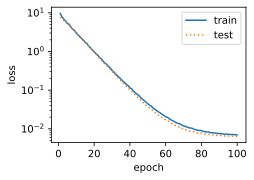

In [6]:
fit_and_polt(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### Quadratic Function Fitting(Underfitting)

final epoch: train loss => 98.0013 test loss => 60.202965
weight: [[20.638206  -6.5477977]] 
bias: [7.779089]


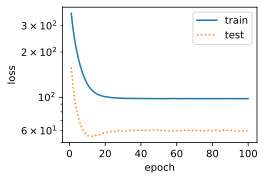

In [7]:
fit_and_polt(quad_features[:n_train, :], quad_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### Linear Function Fitting(Underfitting)

final epoch: train loss => 159.33267 test loss => 102.94731
weight: [[22.666887]] 
bias: [-0.64338624]


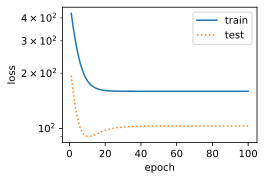

In [8]:
fit_and_polt(features[:n_train, :], features[n_train:, :],
             labels[:n_train], labels[n_train:])

### Insufficient Training Samples(Overfitting)

final epoch: train loss => 0.49096447 test loss => 132.79878
weight: [[2.018278  1.9455485 2.0734744]] 
bias: [2.473768]


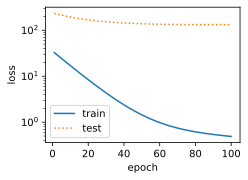

In [9]:
fit_and_polt(poly_features[0:2, :], poly_features[n_train:, :], 
            labels[0:2], labels[n_train:])